In [1]:
import numpy as np
import cv2
import os
import torch
from torch import nn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# get ORB features from dataset
def get_features(path):
    orb = cv2.ORB_create()
    features = []
    labels = []
    IMAGE_SIZE = (128, 128)

    for letter in os.listdir(path):
        letter_path = os.path.join(path, letter)

        if os.path.isdir(letter_path):        
            for image_name in os.listdir(letter_path):
                image_path = os.path.join(letter_path, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
                if image is not None:
                    image = cv2.resize(image, IMAGE_SIZE)
                    _, descriptors = orb.detectAndCompute(image, None)
                
                    if descriptors is not None: 
                        features.append(descriptors)
                        labels.append(letter)

    labels = np.array(labels)
    return features, labels

In [3]:
train_features, train_labels = get_features("ASL_Alphabet_Dataset/asl_alphabet_train")
print(f"Total images: {len(train_features)}")
print(f"Labels: {np.unique(train_labels)}")

Total images: 203107
Labels: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


In [13]:
# Get X_train by finding top N features of each image
N = 150
X = np.empty((len(train_features), N * 32))
y = train_labels

for i in range(len(train_features)):
    current_image = train_features[i]

    if len(current_image) < N:
        padding = np.zeros((N- len(current_image), 32))
        top_features = np.vstack([current_image, padding])
    else:
        top_features = current_image[:N]

    X[i] = top_features.flatten()

In [14]:
# normalise data
scaler = StandardScaler()
X = scaler.fit_transform(X)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# split into validation and train data
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded)

In [15]:
# Use a funnel architecture for the CNN
class ORB_Model(nn.Module):
    def __init__(self, input=(N * 32), output=26):
        super().__init__()
        self.sequence = nn.Sequential(
            nn.Linear(input, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, output)
        )
    
    def forward(self, x):
        x = self.sequence(x)
        return x

In [17]:
# Convert X and y to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

print(f"X_train shape: {X_train_tensor.shape}")
print(f"y_train shape: {y_train_tensor.shape}")
print(f"X_val shape: {X_val_tensor.shape}")
print(f"y_val shape: {y_val_tensor.shape}")

X_train shape: torch.Size([162485, 4800])
y_train shape: torch.Size([162485])
X_val shape: torch.Size([40622, 4800])
y_val shape: torch.Size([40622])


In [18]:
# Train model
model = ORB_Model()   
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

start_time = time.time()

for epoch in range(200):
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch % 10) == 0:
        print(f"Epoch {epoch} | Loss: {loss}")

training_time = time.time() - start_time
print(f"Time taken to train model = {training_time}")

Epoch 0 | Loss: 3.2617671489715576
Epoch 10 | Loss: 3.063706159591675
Epoch 20 | Loss: 2.7641336917877197
Epoch 30 | Loss: 2.527869939804077
Epoch 40 | Loss: 2.307490825653076
Epoch 50 | Loss: 2.1388814449310303
Epoch 60 | Loss: 1.992406964302063
Epoch 70 | Loss: 1.8584586381912231
Epoch 80 | Loss: 1.738769292831421
Epoch 90 | Loss: 1.6609259843826294
Epoch 100 | Loss: 1.576158046722412
Epoch 110 | Loss: 1.4907169342041016
Epoch 120 | Loss: 1.3993576765060425
Epoch 130 | Loss: 1.3751275539398193
Epoch 140 | Loss: 1.3144211769104004
Epoch 150 | Loss: 1.2177376747131348
Epoch 160 | Loss: 1.2712863683700562
Epoch 170 | Loss: 1.2392220497131348
Epoch 180 | Loss: 1.1221617460250854
Epoch 190 | Loss: 1.0642468929290771
Time taken to train model = 673.3932437896729


Accuracy: 70.25%


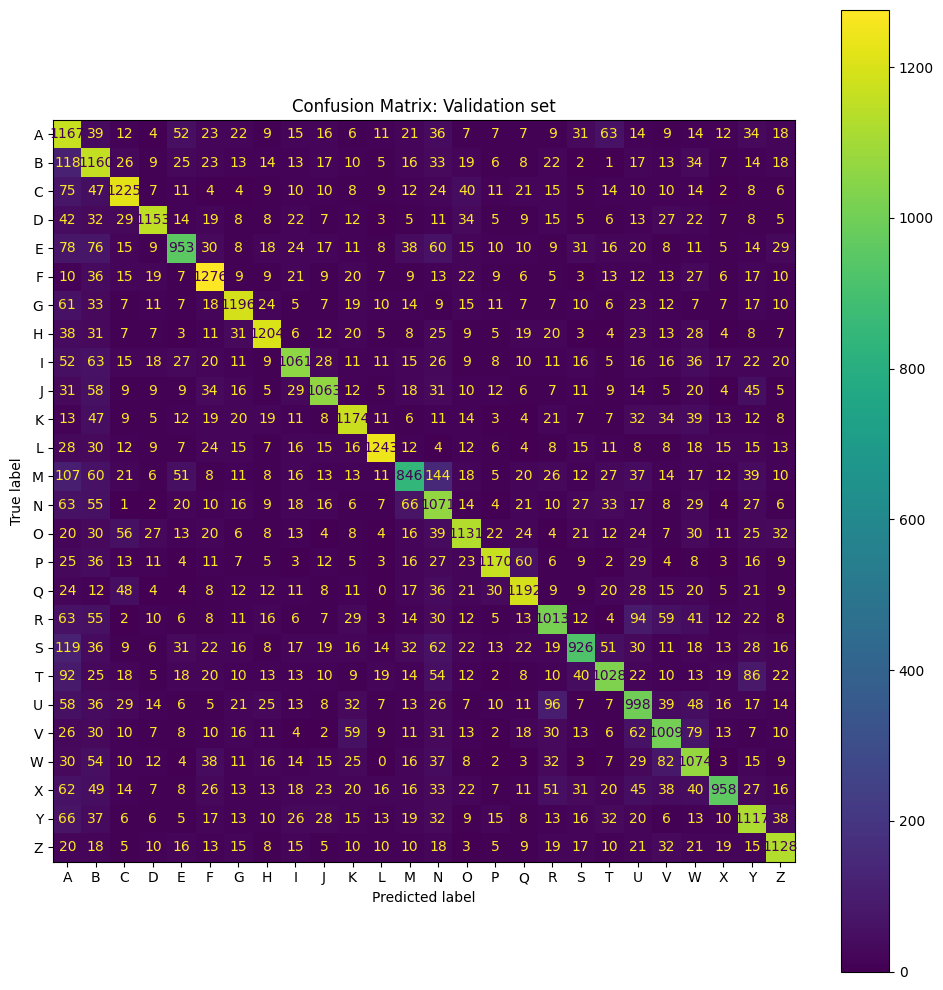

              precision    recall  f1-score   support

           A      0.469     0.704     0.563      1658
           B      0.531     0.706     0.606      1643
           C      0.755     0.760     0.758      1611
           D      0.831     0.758     0.793      1521
           E      0.721     0.626     0.670      1523
           F      0.743     0.796     0.769      1603
           G      0.781     0.770     0.776      1553
           H      0.804     0.776     0.790      1551
           I      0.747     0.683     0.714      1553
           J      0.771     0.720     0.744      1477
           K      0.744     0.753     0.749      1559
           L      0.861     0.791     0.825      1571
           M      0.661     0.545     0.597      1552
           N      0.557     0.687     0.615      1560
           O      0.744     0.704     0.723      1607
           P      0.845     0.771     0.806      1517
           Q      0.779     0.752     0.765      1586
           R      0.681    

In [40]:
# Evaluate on validation set
model.eval()
correct = 0

with torch.no_grad():
    y_pred = model(X_val_tensor)
    _, pred = torch.max(y_pred, 1)
    correct = (pred == y_val).sum().item()

accuracy = correct / len(y_val)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_val_tensor.numpy(), pred.numpy())
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(ax=ax)
plt.title("Confusion Matrix: Validation set")
plt.tight_layout()
plt.show()

val_report = classification_report(y_val_tensor.numpy(), pred.numpy(), 
                                    target_names=encoder.classes_, digits=3)

print(val_report)

In [41]:
# Get test data
def get_test_data(path):
    orb = cv2.ORB_create()
    features = []
    labels = []
    IMAGE_SIZE = (128, 128)

    for image_name in os.listdir(path):
        image_path = os.path.join(path, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is not None:
            image = cv2.resize(image, IMAGE_SIZE)
            _, descriptors = orb.detectAndCompute(image, None)

            if descriptors is not None: 
                features.append(descriptors)
                labels.append(image_name[0])
   
    labels = np.array(labels)
    return features, labels

In [42]:
test_features, test_labels = get_test_data("ASL_Alphabet_Dataset/asl_alphabet_test")

print(f"Total images: {len(test_features)}")
print(f"Labels: {np.unique(test_labels)}")

Total images: 26
Labels: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


In [43]:
# Get X_test by finding top 50 features of each image
X_test = np.empty((len(test_features), N * 32))
y_test = test_labels

for i in range(len(test_features)):
    current_image = test_features[i]

    if len(current_image) < N:
        padding = np.zeros((N - len(current_image), 32))
        test_top_features = np.vstack([current_image, padding])
    else:
        test_top_features = current_image[:N]

    X_test[i] = test_top_features.flatten()

X_test = scaler.transform(X_test)

In [44]:
# Convert X and y to tensors
encoder = LabelEncoder()
y_encoded_test = encoder.fit_transform(y_test)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_encoded_test, dtype=torch.long)

Accuracy: 92.31%


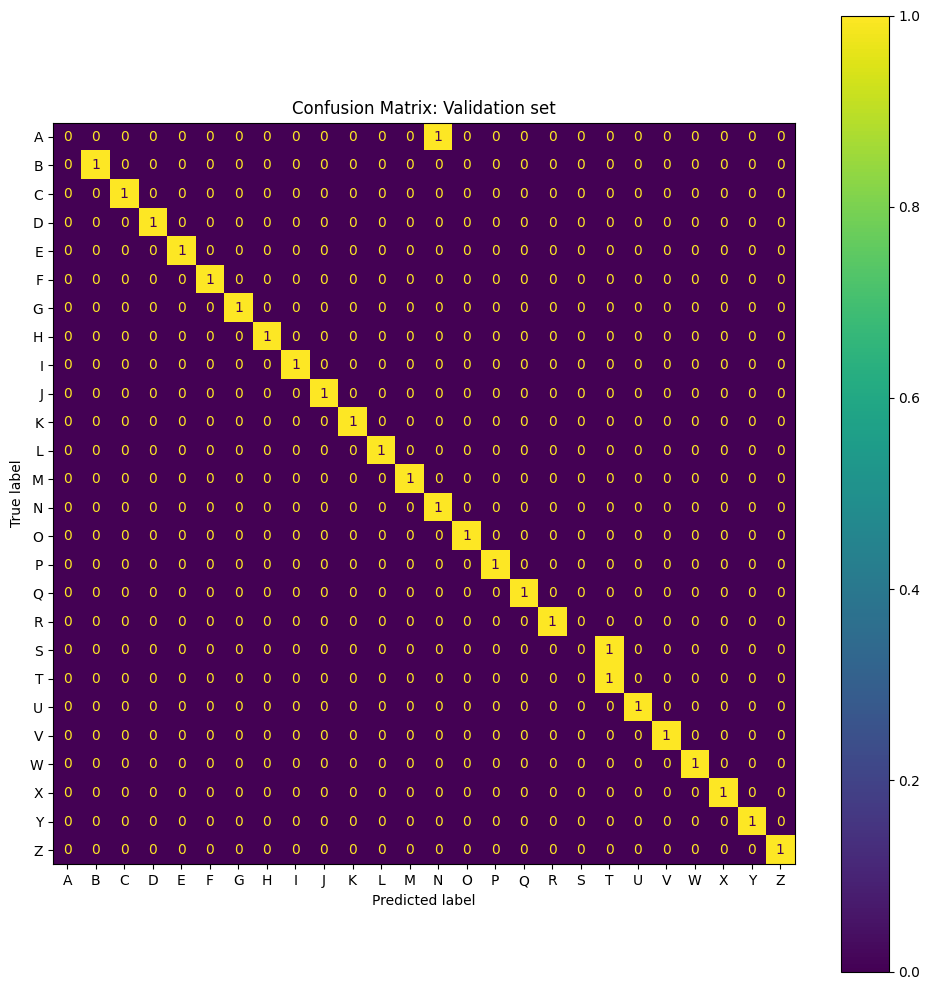

              precision    recall  f1-score   support

           A      0.000     0.000     0.000         1
           B      1.000     1.000     1.000         1
           C      1.000     1.000     1.000         1
           D      1.000     1.000     1.000         1
           E      1.000     1.000     1.000         1
           F      1.000     1.000     1.000         1
           G      1.000     1.000     1.000         1
           H      1.000     1.000     1.000         1
           I      1.000     1.000     1.000         1
           J      1.000     1.000     1.000         1
           K      1.000     1.000     1.000         1
           L      1.000     1.000     1.000         1
           M      1.000     1.000     1.000         1
           N      0.500     1.000     0.667         1
           O      1.000     1.000     1.000         1
           P      1.000     1.000     1.000         1
           Q      1.000     1.000     1.000         1
           R      1.000    

In [ ]:
import warnings
warnings.filterwarnings('ignore') # was getting a lot of warnings as test dataset is tiny
                                  # One photo per letter. Suppressed all warnings, also
                                  # added a larger validation set.

# Get accuracy of model
model.eval()
correct = 0

with torch.no_grad():
    y_pred = model(X_test_tensor)
    _, pred = torch.max(y_pred, 1)
    correct = (pred == y_encoded_test).sum().item()

accuracy = correct / len(y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_test_tensor.numpy(), pred.numpy())
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(ax=ax)
plt.title("Confusion Matrix: Validation set")
plt.tight_layout()
plt.show()

val_report = classification_report(y_test_tensor.numpy(), pred.numpy(), 
                                    target_names=encoder.classes_, digits=3)

print(val_report)